In [50]:
import pandas as pd
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from matplotlib.patches import FancyBboxPatch
import numpy as np
from statsmodels.tsa.seasonal import STL
sns.set(style="whitegrid", rc={"axes.grid": False}) 
from string import ascii_letters
import statsmodels.formula.api as smf
from utils import calculate_injury_statistics,plot_violin_by_injury, seasonality, plot_metrics, plot_kde, plot_metrics_by_athlete, plot_injury_counts,  aggregate_data, impute_missing, plot_predictor_effects

## Process Data Files

In [51]:
from preprocess import PreprocessingPipeline

pipeline = PreprocessingPipeline(
    directory='./',
    scaler='MinMaxScaler',
    workload_column='game_workload_scaled'
)
pipeline.run()


Loading datasets...
injuries: 137 rows, 2 columns, missing entries: 0
injuries: Data on 29 athletes
game_workload: 2400 rows, 3 columns, missing entries: 0
game_workload: Data on 30 athletes
metrics: 43800 rows, 4 columns, missing entries: 0
metrics: Data on 30 athletes
Validating datasets...
Preparing data...
Adding previous injury feature...
Scaling features per athlete...
# of missing data points: game_workload    19500
groin_squeeze        0
hip_mobility         0
dtype: int64, Imputing missing 
Calculating ACWR per athlete...
Data processing completed. Dataset saved as 'data_acwr.csv'.


In [52]:
df = pipeline.final_df
df.head()

,athlete_id,date,groin_squeeze,hip_mobility,game_workload,game_day,injured,previous_injury,game_workload_scaled,groin_squeeze_scaled,hip_mobility_scaled,acute_workload,chronic_workload,acute_chronic_ratio
0,1,2016-05-01,297,36,402.0,NaN,0.0,0,0.511737,0.463277,0.414286,0.511737,0.511737,1.0
1,1,2016-05-02,274,36,402.0,NaN,0.0,0,0.511737,0.398305,0.414286,0.511737,0.511737,1.0
2,1,2016-05-03,291,56,402.0,NaN,0.0,0,0.511737,0.446328,0.700000,0.511737,0.511737,1.0
3,1,2016-05-04,260,24,402.0,NaN,0.0,0,0.511737,0.358757,0.242857,0.511737,0.511737,1.0
4,1,2016-05-05,284,35,402.0,1.0,0.0,0,0.511737,0.426554,0.400000,0.511737,0.511737,1.0


In [53]:

injury_stats = calculate_injury_statistics(df, athlete_column='athlete_id', date_column='date', injury_column='injured')

print("Global Statistics:")
print(f"Total Injuries: {injury_stats['total_injuries']}")
print(f"Average Injury Count Per Athlete: {injury_stats['avg_injury_count_per_athlete']}")
print(f"Average Time to First Injury (days): {injury_stats['avg_time_to_first_injury_days']}")
print(f"Mean Injury Frequency (days per injury): {injury_stats['mean_injury_frequency_days']}\n")

print("Per-Athlete Statistics:")
injury_stats['athlete_injury_statistics'].head()

Global Statistics:
Total Injuries: 137.0
Average Injury Count Per Athlete: 4.0
Average Time to First Injury (days): 113.5
Mean Injury Frequency (days per injury): 242.32167487684728

Per-Athlete Statistics:


,athlete_id,start_date,end_date,days_active,injury_count,injury_frequency_days,first_injury_date,time_to_first_injury
0,1,2016-05-01,2018-04-30,729,12.0,60.750000,2016-05-11,10.0
1,2,2016-05-01,2018-04-30,729,7.0,104.142857,2016-05-04,3.0
2,3,2016-05-01,2018-04-30,729,9.0,81.000000,2016-05-23,22.0
3,4,2016-05-01,2018-04-30,729,5.0,145.800000,2017-08-27,483.0
4,5,2016-05-01,2018-04-30,729,1.0,729.000000,2017-11-05,553.0


## Plot monthly injury count

N of total injuries: 137


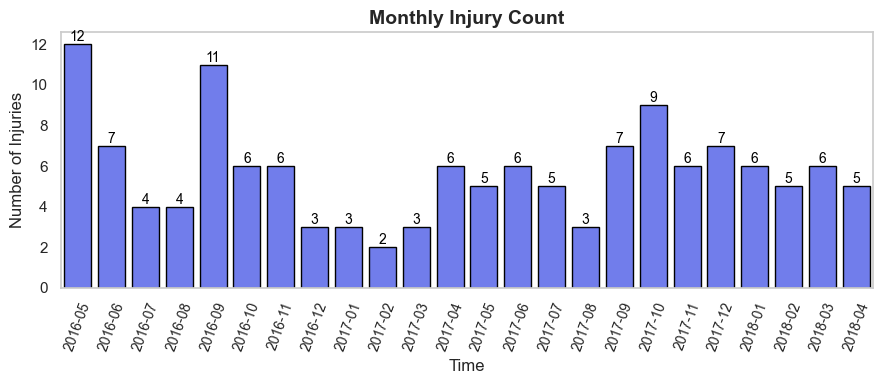

In [54]:

plot_injury_counts(
    data=df,
    date_column='date',
    injury_column='injured',
    frequency='M',  # Options: 'D' (daily), 'W' (weekly), 'M' (monthly)
    title='Monthly Injury Count'
)


## Density plot of weekly injuries

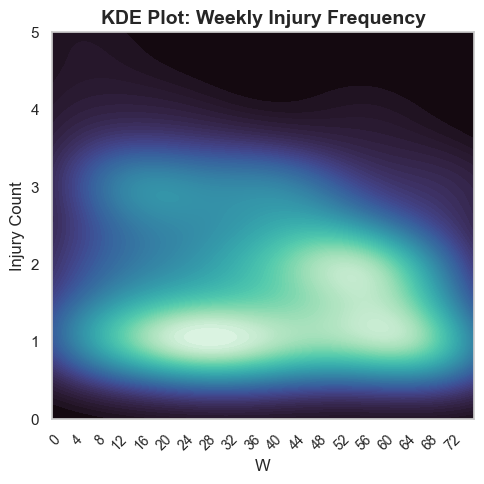

In [55]:

plot_kde(
    data=df,
    date_column='date',
    injury_column='injured',
    frequency='W',  # Weekly aggregation
    title='KDE Plot: Weekly Injury Frequency'
)


## Explore Seasonality

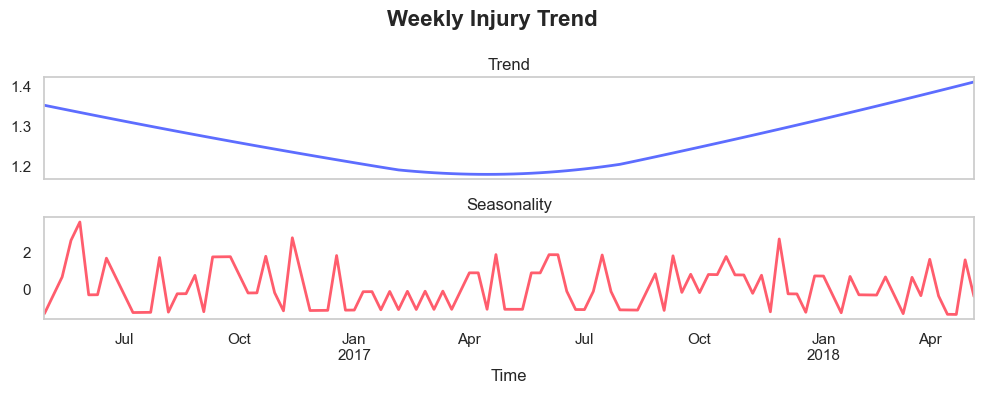

Variance Analysis for Seasonality Significance
Seasonal Variance: 1.3751
Residual Variance: 0.0004
Variance Ratio (Seasonal/Residual): 3156.90
Seasonality is likely significant.


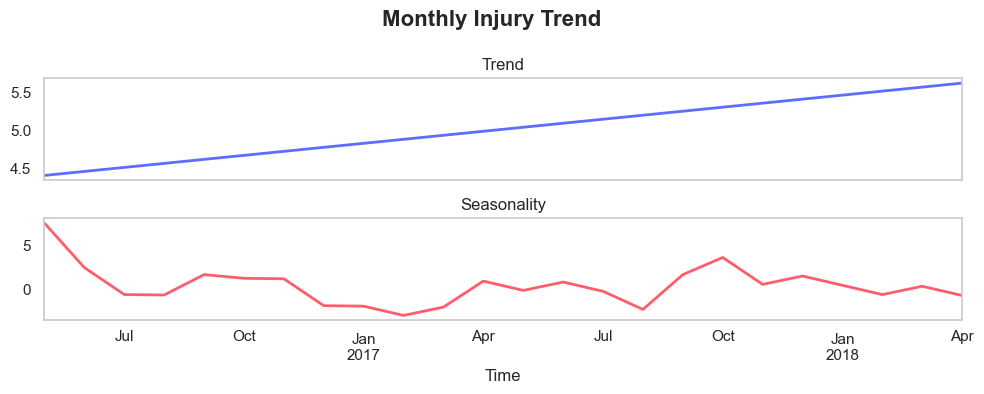

Variance Analysis for Seasonality Significance
Seasonal Variance: 4.6325
Residual Variance: 0.8583
Variance Ratio (Seasonal/Residual): 5.40
Seasonality is likely significant.


In [56]:
seasonality(
    data=df,
    date_column='date',
    target_column='injured',
    frequency='W',  
    seasonal_period=53, 
    title="Weekly Injury Trend"
)
seasonality(
    data=df,
    date_column='date',
    target_column='injured',
    frequency='ME',  
    seasonal_period=13, 
    title="Monthly Injury Trend"
)

## Explore Metrics

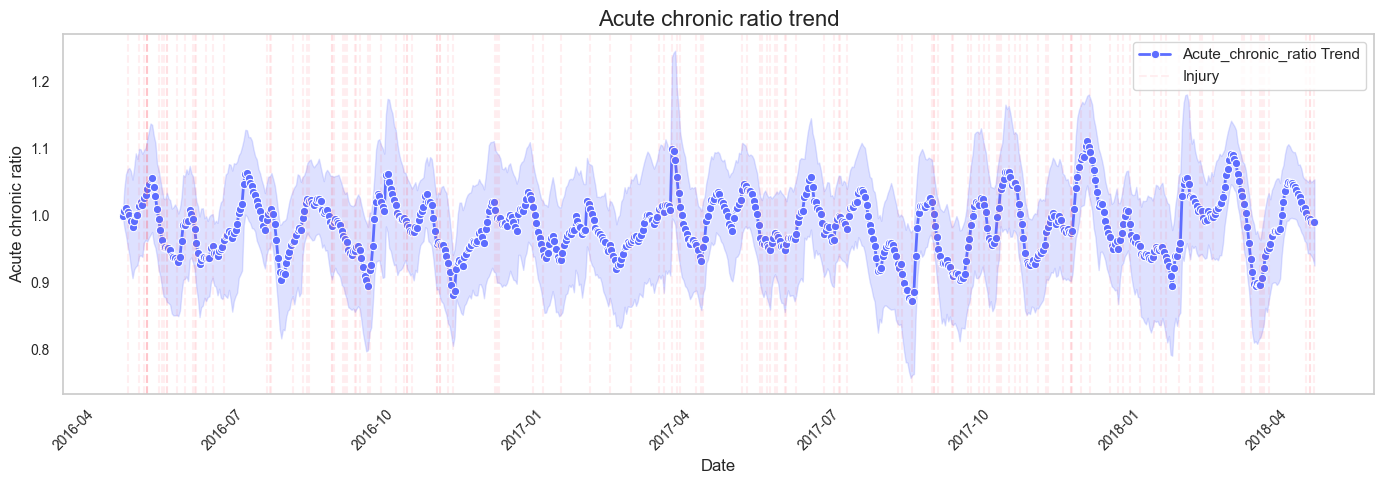

In [8]:
plot_metrics(df, metric='acute_chronic_ratio', outcome='injured')

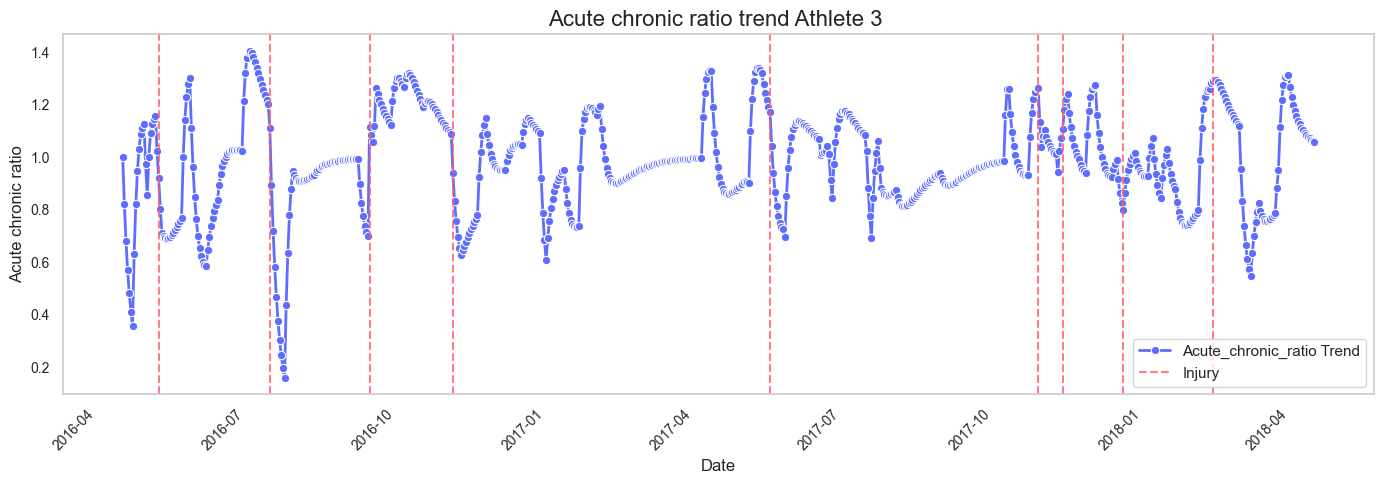

In [61]:

plot_metrics_by_athlete(df, metric='acute_chronic_ratio', outcome='injured', athlete_id=3)


<Axes: >

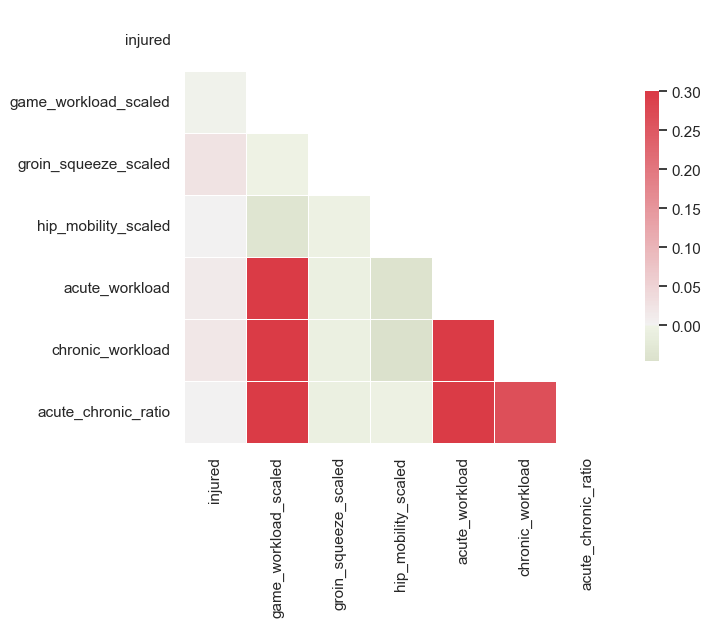

In [68]:
#global relationship between metrics

features = ['injured',  'game_workload_scaled', 'groin_squeeze_scaled', 'hip_mobility_scaled',
       'acute_workload', 'chronic_workload', 'acute_chronic_ratio']


corr = df[features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(7, 7))
cmap = sns.diverging_palette(100, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


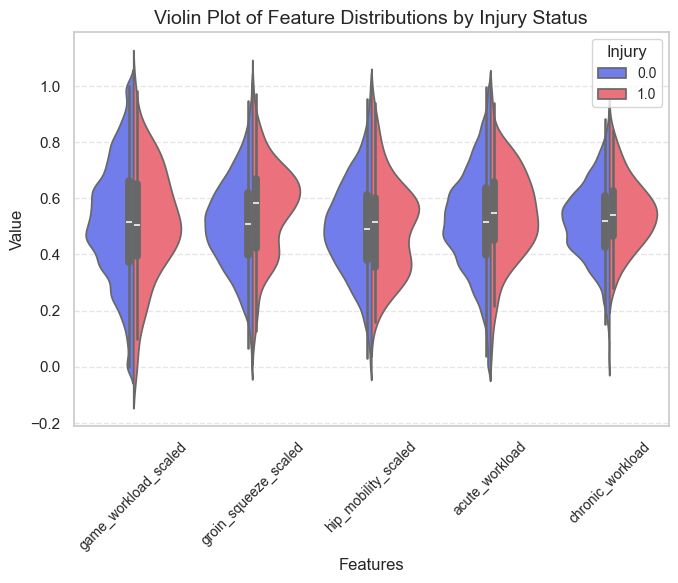

In [67]:
#check overal distribution of metrics

features = [
    'game_workload_scaled', 'groin_squeeze_scaled', 'hip_mobility_scaled',
    'acute_workload', 'chronic_workload', 'injured', 'date'
]
plot_violin_by_injury(df, features)


## Aggregate weekly data

In [69]:
features = [ 
  'game_workload_scaled', 'groin_squeeze_scaled', 'hip_mobility_scaled',
    # 'game_workload', 'groin_squeeze', 'hip_mobility',
    'acute_workload', 'chronic_workload', 'acute_chronic_ratio']

aggregated_data = aggregate_data(
    data=df,
    date_column='date',
    injury_column='injured',
    features=features,
    period='W' 
)

aggregated_data.head()

Processing Athlete ID: 1, Sequence Length: 106
Processing Athlete ID: 2, Sequence Length: 106
Processing Athlete ID: 3, Sequence Length: 106
Processing Athlete ID: 4, Sequence Length: 106
Processing Athlete ID: 5, Sequence Length: 106
Processing Athlete ID: 6, Sequence Length: 106
Processing Athlete ID: 7, Sequence Length: 106
Processing Athlete ID: 8, Sequence Length: 106
Processing Athlete ID: 9, Sequence Length: 106
Processing Athlete ID: 10, Sequence Length: 106
Processing Athlete ID: 11, Sequence Length: 106
Processing Athlete ID: 12, Sequence Length: 106
Processing Athlete ID: 13, Sequence Length: 106
Processing Athlete ID: 14, Sequence Length: 106
Processing Athlete ID: 15, Sequence Length: 106
Processing Athlete ID: 16, Sequence Length: 106
Processing Athlete ID: 17, Sequence Length: 106
Processing Athlete ID: 18, Sequence Length: 106
Processing Athlete ID: 19, Sequence Length: 106
Processing Athlete ID: 20, Sequence Length: 106
Processing Athlete ID: 21, Sequence Length: 106
P

,athlete_id,period,injured,injury_status_next_period,period_number,game_workload_scaled_mean,game_workload_scaled_std,game_workload_scaled_min,game_workload_scaled_max,game_workload_scaled_delta,...,chronic_workload_mean,chronic_workload_std,chronic_workload_min,chronic_workload_max,chronic_workload_delta,acute_chronic_ratio_mean,acute_chronic_ratio_std,acute_chronic_ratio_min,acute_chronic_ratio_max,acute_chronic_ratio_delta
0,1,2016-04-25,0,0,1,0.511737,NaN,0.511737,0.511737,0.000000,...,0.511737,NaN,0.511737,0.511737,0.000000,1.000000,NaN,1.000000,1.000000,0.000000
1,1,2016-05-02,0,1,2,0.437290,0.092851,0.338028,0.511737,0.173709,...,0.501933,0.013719,0.478219,0.511737,0.033518,0.955567,0.059750,0.860091,1.000000,0.139909
2,1,2016-05-09,1,1,3,0.630449,0.130494,0.525822,0.769953,0.244131,...,0.526053,0.013669,0.498339,0.534511,0.036172,1.080556,0.049917,1.005284,1.157416,0.152131
3,1,2016-05-16,1,0,4,0.637156,0.177345,0.525822,0.896714,0.370892,...,0.542951,0.019360,0.531900,0.581198,0.049297,1.060467,0.072384,1.012177,1.196870,0.184693
4,1,2016-05-23,0,0,5,0.574782,0.219921,0.446009,0.896714,0.450704,...,0.596421,0.018418,0.569977,0.623216,0.053239,1.082264,0.133879,0.923055,1.257344,0.334289


In [70]:
# Identify and impute missing values

weekly_summary, missing_info = impute_missing(data=aggregated_data, features=aggregated_data.columns)

weekly_summary.head()


,athlete_id,period,injured,injury_status_next_period,period_number,game_workload_scaled_mean,game_workload_scaled_std,game_workload_scaled_min,game_workload_scaled_max,game_workload_scaled_delta,...,chronic_workload_mean,chronic_workload_std,chronic_workload_min,chronic_workload_max,chronic_workload_delta,acute_chronic_ratio_mean,acute_chronic_ratio_std,acute_chronic_ratio_min,acute_chronic_ratio_max,acute_chronic_ratio_delta
0,1,2016-04-25,0,0,1,0.511737,0.092851,0.511737,0.511737,0.000000,...,0.511737,0.013719,0.511737,0.511737,0.000000,1.000000,0.059750,1.000000,1.000000,0.000000
1,1,2016-05-02,0,1,2,0.437290,0.092851,0.338028,0.511737,0.173709,...,0.501933,0.013719,0.478219,0.511737,0.033518,0.955567,0.059750,0.860091,1.000000,0.139909
2,1,2016-05-09,1,1,3,0.630449,0.130494,0.525822,0.769953,0.244131,...,0.526053,0.013669,0.498339,0.534511,0.036172,1.080556,0.049917,1.005284,1.157416,0.152131
3,1,2016-05-16,1,0,4,0.637156,0.177345,0.525822,0.896714,0.370892,...,0.542951,0.019360,0.531900,0.581198,0.049297,1.060467,0.072384,1.012177,1.196870,0.184693
4,1,2016-05-23,0,0,5,0.574782,0.219921,0.446009,0.896714,0.450704,...,0.596421,0.018418,0.569977,0.623216,0.053239,1.082264,0.133879,0.923055,1.257344,0.334289


In [71]:
predictors = [ 'injured', 
       'period_number', 
       'game_workload_scaled_mean',
       'game_workload_scaled_std', 
       'game_workload_scaled_delta',
       'groin_squeeze_scaled_mean', 'groin_squeeze_scaled_std',
       'groin_squeeze_scaled_delta', 'hip_mobility_scaled_mean',
       'hip_mobility_scaled_std',
       'hip_mobility_scaled_delta',
       'acute_workload_mean', 'acute_workload_std', 
       'acute_workload_delta',
       'chronic_workload_mean',
       'chronic_workload_std', 
       'chronic_workload_delta', 
        'acute_chronic_ratio_mean',
       'acute_chronic_ratio_std', 
        'acute_chronic_ratio_delta']

## Mixed effect model 

hypothesis: weekly average value of a metric is significantly associated with subsequent's week injury

In [72]:

results = []

for predictor in predictors:
    formula = f"injury_status_next_period~ {predictor}"
    model = smf.mixedlm(formula, data=weekly_summary.fillna(0), groups="athlete_id")
    result = model.fit()
    # print(result.summary())
    
    conf_int = result.conf_int()
    lower_ci = conf_int.loc[predictor, 0] 
    upper_ci = conf_int.loc[predictor, 1]  
    
    results.append({
        'predictor': predictor,
        'coef': result.params[predictor],
        'pval': result.pvalues[predictor],
        'lower_ci': lower_ci,
        'upper_ci': upper_ci
    })

results_df = pd.DataFrame(results)
results_df.head()


,predictor,coef,pval,lower_ci,upper_ci
0,injured,0.016486,0.352614,-0.018276,0.051249
1,period_number,-0.000038,0.735913,-0.000262,0.000185
2,game_workload_scaled_mean,0.060924,0.001200,0.024057,0.097791
3,game_workload_scaled_std,0.097616,0.017435,0.017140,0.178092
4,game_workload_scaled_delta,0.053681,0.003775,0.017356,0.090007


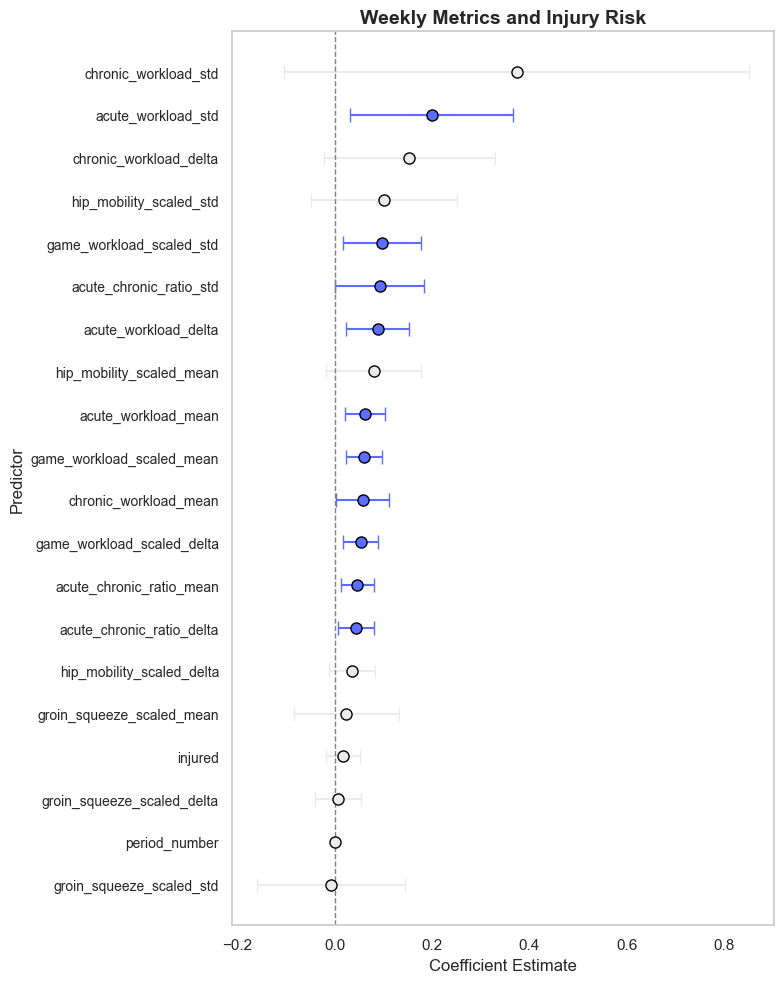

In [73]:
plot_predictor_effects(results_df)

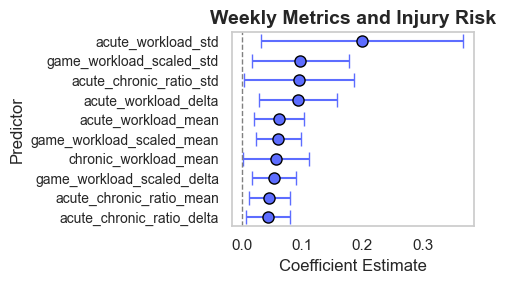

In [25]:

#filter for significant 

plot_predictor_effects(results_df[results_df['pval']<=0.05])